In [150]:
#import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
from matplotlib import pyplot as plt
import mapclassify
# To display plots, maps, charts etc in the notebook
%matplotlib inline

# For area weighted interpolation
from tobler import area_weighted
from tobler.area_weighted import area_interpolate, area_tables

EBLL DATA SECTION
    read in data
    rename columns
    fix the census tract columns
    only keep the tracts in alameda county

In [151]:
#read in the csv file of elevated blood lead levels by census tract in CA
EBLL_df = pd.read_csv(rf'C:\Users\amarq\Python_Projects\raw_data\Lead Testing by CA Census Tract 2013 to 2018.csv')
EBLL_df.shape

(7632, 4)

In [152]:
#rename columns
EBLL_renaming = {'County - Census Tract' : 'Tract',
       'Number of Children Under Age 6 with Elevated Lead Levels':'Number_EBLL',
       'Number of Tests that Children in Medi-Cal Ages 1 and 2 Should have Received':'Number_MediCal',
       'Number of Tests that Children in Medi-Cal Ages 1 and 2 Missed':'Number_Not_Tested'}

EBLL_df.rename(columns=EBLL_renaming, inplace = True)


In [153]:
# EBLL_df['Tract'].head()

In [154]:
#create a county and census tract column
EBLL_df['County'] = EBLL_df['Tract'].str.split(" ", expand=True).drop(columns=[1,2,3,4,5,6,7])
EBLL_df['Census_Tract'] = EBLL_df['Tract'].str.split(" ", expand=True).drop(columns=[0,1,2,3,4,6,7])

In [155]:
#drop the tract data since we've gotten the info we need
EBLL_df.drop(columns = 'Tract',inplace = True)

In [156]:
EBLL_df.shape

(7632, 5)

In [157]:
#keep only alameda county
EBLL_ac__df = EBLL_df[EBLL_df['County'] == 'Alameda']

In [158]:
EBLL_ac__df.shape

(332, 5)

In [159]:
#double check that it works
EBLL_ac__df.head()

,Number_EBLL,Number_MediCal,Number_Not_Tested,County,Census_Tract
0,9,110,78,Alameda,4003
1,7,79,57,Alameda,4004
2,2,96,64,Alameda,4005
3,2,61,Redacted*,Alameda,4006
4,12,229,156,Alameda,4007


In [160]:
#there is an issue with interpolation later on if there are any NaN/redacted
# values, need to get rid of it now

# EBLL_ac__df[EBLL_ac__df['Number_Not_Tested'] == 'Redacted*']
# above code shows 73 records in Alameda County with redacted not tested
# so, keeping all the other ones

EBLL_ac__df = EBLL_ac__df[EBLL_ac__df['Number_Not_Tested'] != 'Redacted*']
# goes from 332 rows to 259 rows

In [161]:
EBLL_ac__df['Number_Not_Tested'] = EBLL_ac__df['Number_Not_Tested'].astype(str).astype(float)

In [162]:
#going to turn the objects into float to see if that helps later
# interpolation issues

#turn into strings and remove any commas
EBLL_ac__df['Number_MediCal'] = EBLL_ac__df['Number_MediCal'].str.replace(',', '')

In [163]:
EBLL_ac__df['Number_MediCal'] = EBLL_ac__df['Number_MediCal'].astype(str).astype(float)

In [164]:
# EBLL_ac__df['Number_MediCal'].describe()
#worked great

In [165]:
EBLL_ac__df['Number_Not_Tested'].astype(str).astype(float)

0       78.0
1       57.0
2       64.0
4      156.0
5      113.0
       ...  
323    195.0
324    119.0
326     80.0
328    100.0
331     78.0
Name: Number_Not_Tested, Length: 259, dtype: float64

ACS Data Section

In [166]:
#bring in ACS Data
Age_of_Structure_df = pd.read_csv(rf'C:\Users\amarq\Python_Projects\raw_data\ACS_5Y_2018.B25126_AgeofStructureBuilt_Alameda County.csv')

In [167]:
#cleaning up data with goal of creating total columns for age of structure by age for renters, owners and both

#start by dropping all MOE columns
moe_columns = []
for i in Age_of_Structure_df.columns:
    if i.startswith('Margin') == True:
        moe_columns.append(i) 
    else:
        pass
Building_Ages_df = Age_of_Structure_df.drop(columns = moe_columns)
# Building_Ages_df.columns

In [168]:
#creating summation columns by using list comprehension and a list of the years/columns in a loop
year = ['2014','2010','2000','1990','1980','1970','1960','1950','1940','1939']
year_names = ['built_'+i for i in year]
renter_names = ['built_renter_'+i for i in year]

for i in range(len(year)): #loop over each year
    built_columns = [col for col in Building_Ages_df.columns if year[i] in col] #create list of columns with year[i] in it
    built_renter_columns = [col for col in Building_Ages_df.columns if (year[i] in col) and ('Renter' in col)] #create list of columns with year[i]and 'Renter' in it

    Building_Ages_df[year_names[i]] = Building_Ages_df.loc[:,built_columns].sum(axis='columns') #create new column populated by sum of columns with that year in it
    Building_Ages_df[renter_names[i]] = Building_Ages_df.loc[:,built_renter_columns].sum(axis='columns') #create new column populated by sum of columns with that year in it

In [169]:
#double checking that the summed thing worked

# print(Building_Ages_df['Estimate!!Total!!Owner occupied!!Householder 15 to 34 years!!Built 2014 or later'].sum() +\
# Building_Ages_df['Estimate!!Total!!Owner occupied!!Householder 35 to 64 years!!Built 2014 or later'].sum() +\
# Building_Ages_df['Estimate!!Total!!Owner occupied!!Householder 65 years and over!!Built 2014 or later'].sum() +\
# Building_Ages_df['Estimate!!Total!!Renter occupied!!Householder 15 to 34 years!!Built 2014 or later'].sum() +\
# Building_Ages_df['Estimate!!Total!!Renter occupied!!Householder 35 to 64 years!!Built 2014 or later'].sum() +\
# Building_Ages_df['Estimate!!Total!!Renter occupied!!Householder 65 years and over!!Built 2014 or later'].sum()
#  == Building_Ages_df['built_2014'].sum())


#it worked


In [170]:
#rename the total columns to be less weird
Building_Ages_df.rename(columns = {'Estimate!!Total' : 'households_total', 'Estimate!!Total!!Renter occupied' : 'households_renters'},
                       inplace = True) 

In [171]:
#creating dataframe of only the columns that I want
columns_to_keep = ['GEO_ID', 'Geographic Area Name', 'households_total', 'households_renters'] +\
year_names + renter_names

ba_sums_df = Building_Ages_df[columns_to_keep].copy()
# ba_sums_df.columns

In [172]:
ba_sums_df.head()

,GEO_ID,Geographic Area Name,pop_total,pop_renters,built_2014,built_2010,built_2000,built_1990,built_1980,built_1970,...,built_renter_2014,built_renter_2010,built_renter_2000,built_renter_1990,built_renter_1980,built_renter_1970,built_renter_1960,built_renter_1950,built_renter_1940,built_renter_1939
0,1400000US06001441501,"Census Tract 4415.01, Alameda County, California",1796,162,0,0,279,95,1283,97,...,0,0,0,16,108,38,0,0,0,0
1,1400000US06001404700,"Census Tract 4047, Alameda County, California",790,110,7,0,9,14,16,35,...,0,0,0,0,5,0,0,38,9,58
2,1400000US06001442500,"Census Tract 4425, Alameda County, California",2264,1019,0,0,45,43,389,386,...,0,0,45,29,342,215,195,162,12,19
3,1400000US06001450300,"Census Tract 4503, Alameda County, California",1814,565,0,105,177,104,215,254,...,0,38,148,104,76,78,114,0,7,0
4,1400000US06001450607,"Census Tract 4506.07, Alameda County, California",2445,1562,62,0,676,590,345,267,...,37,0,255,448,345,200,107,62,60,48


In [173]:
#function from UC Berkeley's 2020 Data for Housing Team
# Census FTP Site
BASE_GEO = "https://www2.census.gov/geo/tiger/"
California_Tracts_GDF = rf'C:\Users\amarq\Python_Projects\out_data\calitracts.json'

def fetch_tract_geodata(BASE, year, state, out_file_name):
    '''
    The function below fetches Census cartographic boundary files from the Census FTP site. 
    The function reads the zipped geodata from the FTP url and saves it in memory as a pandas 
    geodataframe. Then it saves the geodata to a geojson file.
    
    Parameters:
        BASE (str): base url for the data
        year (int): the year of data
        state (str): 2-digit state FIPS code
        out_file_name (str): file name for the output geojson
        
    Returns:
    
        gdf: a geodataframe of Census tract boundaries
    
    '''
    # Start function
    print("...fetching Census tract boundaries")
    
    # Build enhanced base url
    param_geo = "GENZ"+str(year)+ "/shp/cb_"+str(year)+"_"+state+"_tract_500k.zip"
    
    # Read in tracts geodata
    tracts = gpd.read_file(BASE+param_geo)
    
    # Save tract boundaries to file as a geojson
    print(f"...saving tract boundaries to file: {out_file_name}")
    tracts.to_file(driver='GeoJSON', filename=out_file_name)
    print("saved")
    
    # Return geodataframe
    return tracts

In [174]:
tracts_gdf = fetch_tract_geodata(BASE_GEO,2018,'06',California_Tracts_GDF)

...fetching Census tract boundaries
...saving tract boundaries to file: C:\Users\amarq\Python_Projects\out_data\calitracts.json
saved


In [175]:
#create alameda county only census tracts
ac_tracts_gdf = tracts_gdf[tracts_gdf['COUNTYFP'] == '001']

In [176]:
#joining acs 'Geo_ID with the tracts geodatafromes 'AFFGEOID'. ac_tracts_gdf needs to be in the left
#first rename GEOID as AFFGEOID so that we can merge on that attribute
ba_sums_df.rename(columns={"GEO_ID": "AFFGEOID"},inplace=True) 
#second, perform the merge on the geodatagrame
ba_sums_gdf = ac_tracts_gdf.merge(ba_sums_df, on='AFFGEOID')
# ba_sums_gdf.head()

Bringing EBLL data into the geodataframe
    EBLL has fewer tracts than the ACS. So, need to pull all the EBLL data into the GDF

In [177]:
#joining acs 'Geo_ID with the tracts geodatafromes 'AFFGEOID'. ac_tracts_gdf needs to be in the left
#first rename 'NAME' in ac_tracts_gdf as 'Census_Tract' so that we can merge on the 'Census_Tract'
ba_sums_gdf.rename(columns={"NAME": "Census_Tract"},inplace=True) 


In [178]:
#second, perform the merge on the geodatagrame
total_gdf = ba_sums_gdf.merge(EBLL_ac__df, on='Census_Tract', how='left')

In [179]:
total_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   STATEFP               360 non-null    object  
 1   COUNTYFP              360 non-null    object  
 2   TRACTCE               360 non-null    object  
 3   AFFGEOID              360 non-null    object  
 4   GEOID                 360 non-null    object  
 5   Census_Tract          360 non-null    object  
 6   LSAD                  360 non-null    object  
 7   ALAND                 360 non-null    int64   
 8   AWATER                360 non-null    int64   
 9   geometry              360 non-null    geometry
 10  Geographic Area Name  360 non-null    object  
 11  pop_total             360 non-null    int64   
 12  pop_renters           360 non-null    int64   
 13  built_2014            360 non-null    int64   
 14  built_2010            360 non-null    int64   
 15

In [180]:
#drop the columns that aren't needed anymore to create the final GDF for anlaysis
total_gdf = total_gdf.drop(columns = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID','County','LSAD'])


In [181]:
#keeping only the data that fits within the city boundaries of Oakland

#first, read in the Oakland boundaries
oakland_bounds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland City Limits.geojson')

In [182]:
#spatial join of city boundaries and census tracts
#first check if the CRS of each equal each other
# oakland_bounds.crs == gdf.crs it's false
#review each CRS
print(oakland_bounds.crs)
print(total_gdf.crs)
#transforming the Oakland Boundaries CRS to match the census
oakland_bounds.to_crs(total_gdf.crs,inplace=True)
oakland_bounds.crs == total_gdf.crs

epsg:4326
epsg:4269


True

In [183]:
# help(gpd.clip)

In [184]:
#second, clip the gdf into the City of Oakland
oakland_clip_gdf = gpd.clip(total_gdf,oakland_bounds).reset_index(drop=True)

In [185]:
#oakland_clip_gdf.plot()
#Coakland_clip_gdf.head()

#it worked

In [186]:
#need to identify the NaN
# total_gdf.drop(columns='Number_Not_Tested', inplace = True)

In [187]:
#current issue is that some census tracts are outside of oakland except
# just a little bit so need to do that interpolation thing
extensives = ['pop_total','pop_renters','Number_EBLL','Number_MediCal','Number_Not_Tested']+ year_names + renter_names
intensives = ['Census_Tract']
ai_gdf = area_interpolate(total_gdf, oakland_clip_gdf,
                          extensive_variables = extensives,
                          allocate_total=False)

nan values in variable: Number_EBLL, replacing with 0.0
nan values in variable: Number_MediCal, replacing with 0.0
nan values in variable: Number_Not_Tested, replacing with 0.0


C:\Users\amarq\AppData\Local\Continuum\anaconda3\lib\site-packages\tobler\area_weighted\area_weighted.py:249: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  den = source_df["geometry"].area.values


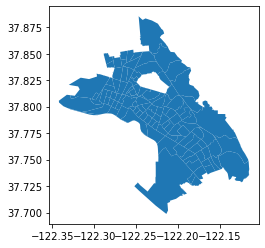

In [188]:
ai_gdf.plot()

In [79]:
ai_gdf.head()

,pop_total,pop_renters,Number_EBLL,Number_MediCal,built_2014,built_2010,built_2000,built_1990,built_1980,built_1970,...,built_renter_2010,built_renter_2000,built_renter_1990,built_renter_1980,built_renter_1970,built_renter_1960,built_renter_1950,built_renter_1940,built_renter_1939,geometry
0,656.999984,373.999991,0.000000,0.000000,0.000000e+00,0.000000e+00,15.000000,6.000000,17.000000,69.999998,...,0.000000e+00,0.000000,6.000000,4.000000,62.999998,27.999999,18.000000,19.000000,235.999994,"POLYGON ((-122.26807 37.84414, -122.26514 37.8..."
1,1014.869338,718.379732,7.776777,127.344716,3.701217e-14,5.372734e-15,40.828077,18.469844,36.939689,50.549047,...,5.372734e-15,40.828077,11.665165,31.107106,39.855980,28.190815,89.432930,82.628251,394.671409,"POLYGON ((-122.28553 37.83980, -122.28319 37.8..."
2,1575.999940,1277.999952,15.999999,367.999986,0.000000e+00,0.000000e+00,48.999998,59.999998,152.999994,28.999999,...,0.000000e+00,14.999999,59.999998,138.999995,28.999999,43.999998,107.999996,84.999997,797.999970,"POLYGON ((-122.27861 37.82688, -122.26856 37.8..."
3,1462.999933,1002.999954,7.000000,119.999994,0.000000e+00,0.000000e+00,149.999993,247.999989,184.999992,253.999988,...,0.000000e+00,29.999999,153.999993,129.999994,135.999994,51.999998,34.999998,43.999998,421.999981,"POLYGON ((-122.27476 37.79883, -122.27127 37.8..."
4,637.999992,440.999994,0.000000,59.999999,0.000000e+00,4.000000e+00,257.999997,142.999998,30.000000,17.000000,...,4.000000e+00,169.999998,70.999999,12.000000,11.000000,23.000000,5.000000,23.000000,121.999998,"POLYGON ((-122.27956 37.80045, -122.27598 37.8..."


In [148]:
ai_gdf.columns

Index(['pop_total', 'pop_renters', 'Number_EBLL', 'Number_MediCal',
       'Number_Not_Tested', 'built_2014', 'built_2010', 'built_2000',
       'built_1990', 'built_1980', 'built_1970', 'built_1960', 'built_1950',
       'built_1940', 'built_1939', 'built_renter_2014', 'built_renter_2010',
       'built_renter_2000', 'built_renter_1990', 'built_renter_1980',
       'built_renter_1970', 'built_renter_1960', 'built_renter_1950',
       'built_renter_1940', 'built_renter_1939', 'geometry'],
      dtype='object')

Creating New Variables of Interest

In [50]:
#now, on interpolated data, create a variable that is percentage of renters living in pre-1950 homes out of total
ai_gdf['p_1950renters'] = (ai_gdf['built_renter_1950'] + ai_gdf['built_renter_1940']\
+ ai_gdf['built_renter_1939'])/ai_gdf['pop_total']

Index(['Number_EBLL', 'Number_MediCal', 'Number_Not_Tested', 'County',
       'Census_Tract'],
      dtype='object')

In [211]:
ai_gdf['n_pre1950renters'] = (ai_gdf['built_renter_1950'] + ai_gdf['built_renter_1940']\
+ ai_gdf['built_renter_1939'])

In [193]:
# create new column for percentage of medical eligible children who tested positive
ai_gdf['p_EBLL_of_Medical'] = ai_gdf['Number_EBLL'] /ai_gdf['Number_MediCal']

In [191]:
#read in oakland council districts
oakland_cds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland Council Districts.geojson')

In [195]:
#test crs of oakland_cds
# oakland_cds.crs == ai_gdf.crs - false, they aren't the same
oakland_cds.to_crs(ai_gdf.crs,inplace=True)
oakland_bounds.crs == ai_gdf.crs

True

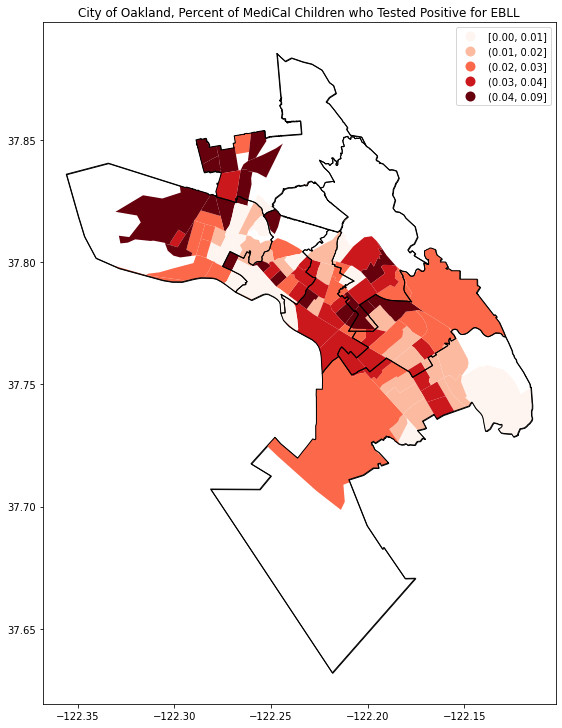

In [219]:
# Choropleth for 
fig, ax = plt.subplots(figsize = (10,10)) 

#add in the city of oakland boundaries
oakland_bounds.plot(color='white',
                edgecolor='black',
                linewidth=1,
                ax=ax)

ai_gdf.plot(column='p_EBLL_of_Medical', 
         cmap='Reds',
         scheme='quantiles',
         legend=True,
#          legend_kwds={'label': "% MediCal Children with Elevated Blood Lead Levels",
#                       'orientation': "horizontal"},
         ax=ax)

#add the council districts as our background layer
oakland_cds.plot(color='none',
                edgecolor='black',
                linewidth=1,
                ax=ax)

# Create titles
plt.tight_layout()
plt.title("City of Oakland, Percent of MediCal Children who Tested Positive for EBLL")

# Save figure 
plt.savefig(r"C:\Users\amarq\Python_Projects\out_maps\OaklandEBLLpercentage.jpeg")

#plot hte figure
plt.show()

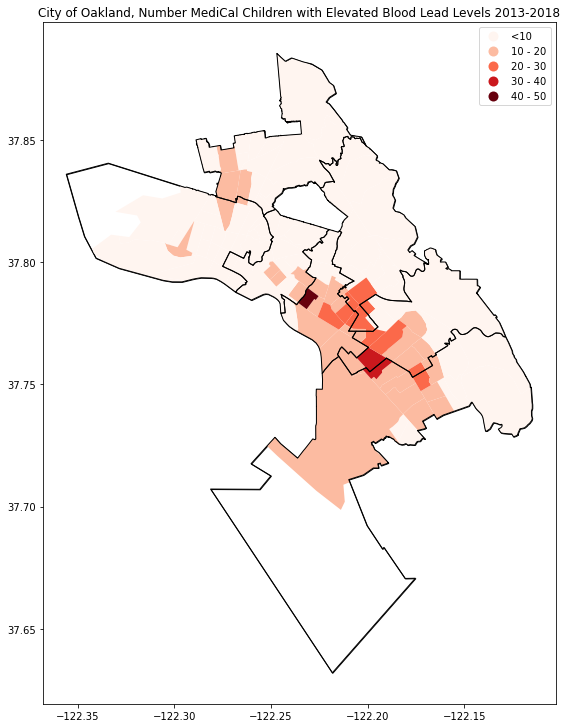

In [216]:
# Choropleth for total number EBLL
fig, ax = plt.subplots(figsize = (10,10)) 

#add in the city of oakland boundaries
oakland_bounds.plot(color='white',
                edgecolor='black',
                linewidth=1,
                ax=ax)

ai_gdf.plot(column='Number_EBLL', 
         cmap='Reds',
         scheme='userdefined',
         classification_kwds={'bins':[10,20,30,40,50]},
         legend=True,
         ax=ax)

# Create a custom legend
legend_labels_list = ['<10','10 - 20','20 - 30','30 - 40','40 - 50']

# Apply the legend to the map
for j in range(0,len(ax.get_legend().get_texts())):
        ax.get_legend().get_texts()[j].set_text(legend_labels_list[j])

#add the council districts as our background layer
oakland_cds.plot(color='none',
                edgecolor='black',
                linewidth=1,
                ax=ax)

# Create titles
plt.tight_layout()
plt.title("City of Oakland, Number MediCal Children with Elevated Blood Lead Levels 2013-2018")

# Save figure 
plt.savefig(r"C:\Users\amarq\Python_Projects\out_maps\OaklandEBLLnumbers.png")

#plot hte figure
plt.show()

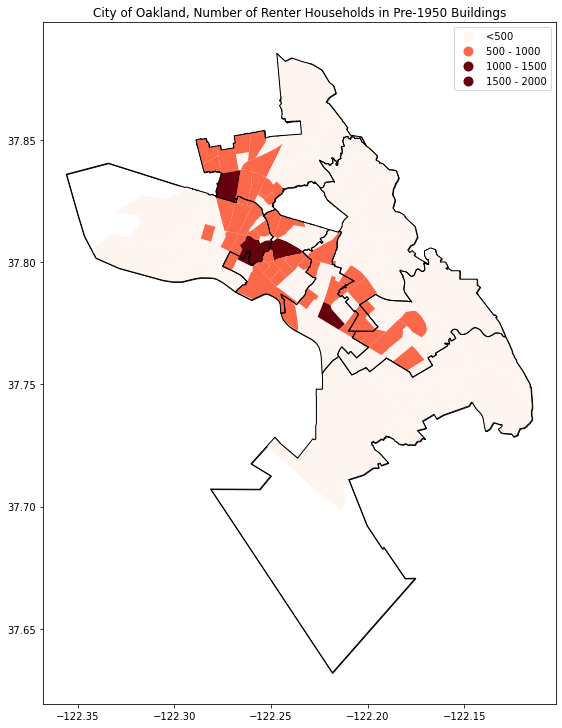

In [217]:
# Choropleth for number of renters in pre-1950 buildings 

fig, ax = plt.subplots(figsize = (10,10)) 

#add in the city of oakland boundaries
oakland_bounds.plot(color='white',
                edgecolor='black',
                linewidth=1,
                ax=ax)

ai_gdf.plot(column='n_pre1950renters', 
         cmap='Reds',
         scheme='userdefined',
         classification_kwds={'bins':[500,1000,1500,2000]},
         legend=True,
         ax=ax)

# Create a custom legend
legend_labels_list = ['<500','500 - 1000','1000 - 1500','1500 - 2000']

# Apply the legend to the map
for j in range(0,len(ax.get_legend().get_texts())):
        ax.get_legend().get_texts()[j].set_text(legend_labels_list[j])

#add the council districts as our background layer
oakland_cds.plot(color='none',
                edgecolor='black',
                linewidth=1,
                ax=ax)

# Create titles
plt.tight_layout()
plt.title("City of Oakland, Number of Renter Households in Pre-1950 Buildings")

# Save figure 
plt.savefig(r"C:\Users\amarq\Python_Projects\out_maps\Oaklandnumberpre1950renters.png")

#plot hte figure
plt.show()